In [3]:
library(tree)
library(randomForest)
Starbucks = read.csv("starbucks.csv", header=TRUE)

set.seed(1)
train = sample(1:nrow(Starbucks), nrow(Starbucks)/2)
starbucks.test = Starbucks[-train, "avg_stars"]

tree.starbucks = tree(avg_stars~., Starbucks, subset=train)

bag.starbucks = randomForest(avg_stars~., data=Starbucks, subset=train, importance=TRUE, ntree=25)


dim(Starbucks)

[1] 410   8

In [4]:
yhat.bag = predict(bag.starbucks,newdata=Starbucks[-train,])
mean((yhat.bag-starbucks.test)^2)

[1] 0.3538793

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


,var,rel.inf
percent_caucasian,percent_caucasian,26.34291
total_population,total_population,23.58281
yearly_household_income,yearly_household_income,21.64636
people_per_household,people_per_household,19.49474
price_range,price_range,4.513491
is_wheelchair_accessible,is_wheelchair_accessible,4.419691
has_wifi,has_wifi,0


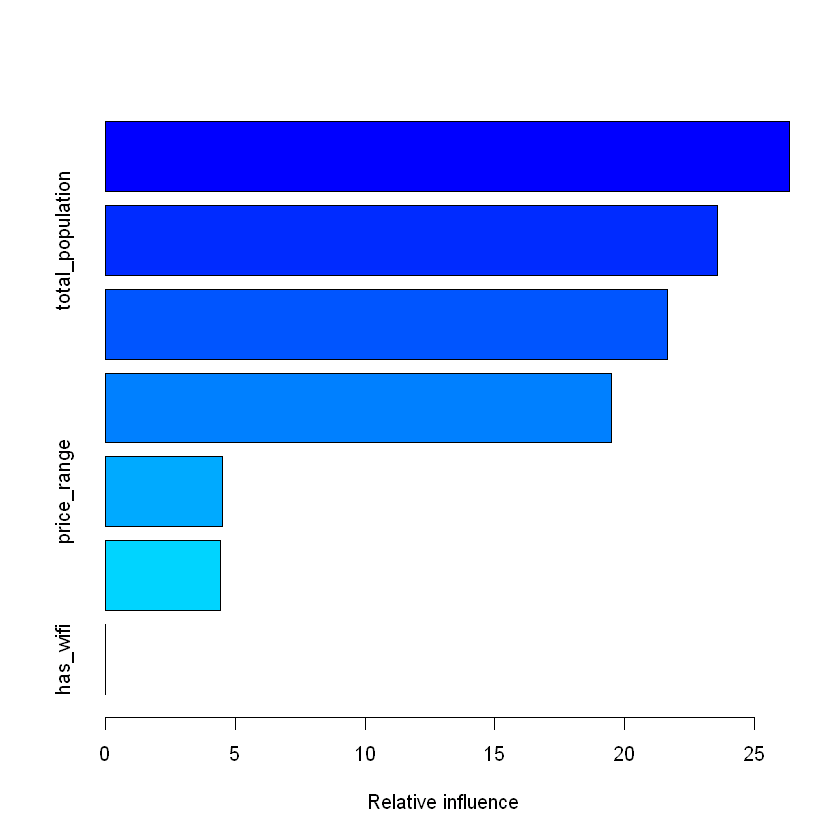

In [5]:
library(gbm)
set.seed(1)

starbucks.scale = data.frame(scale(Starbucks))
boost.starbucks = gbm(as.factor(avg_stars)~., data=Starbucks[train,], distribution="gaussian", n.trees = 5000, interaction.depth=4)
summary(boost.starbucks)

In [6]:
tree.starbucks = tree(as.factor(avg_stars)~.-avg_stars, Starbucks, subset=train)
summary(tree.starbucks)


Classification tree:
tree(formula = as.factor(avg_stars) ~ . - avg_stars, data = Starbucks, 
    subset = train)
Variables actually used in tree construction:
[1] "percent_caucasian"       "total_population"       
[3] "yearly_household_income" "price_range"            
[5] "people_per_household"   
Number of terminal nodes:  23 
Residual mean deviance:  2.359 = 429.3 / 182 
Misclassification error rate: 0.4829 = 99 / 205 

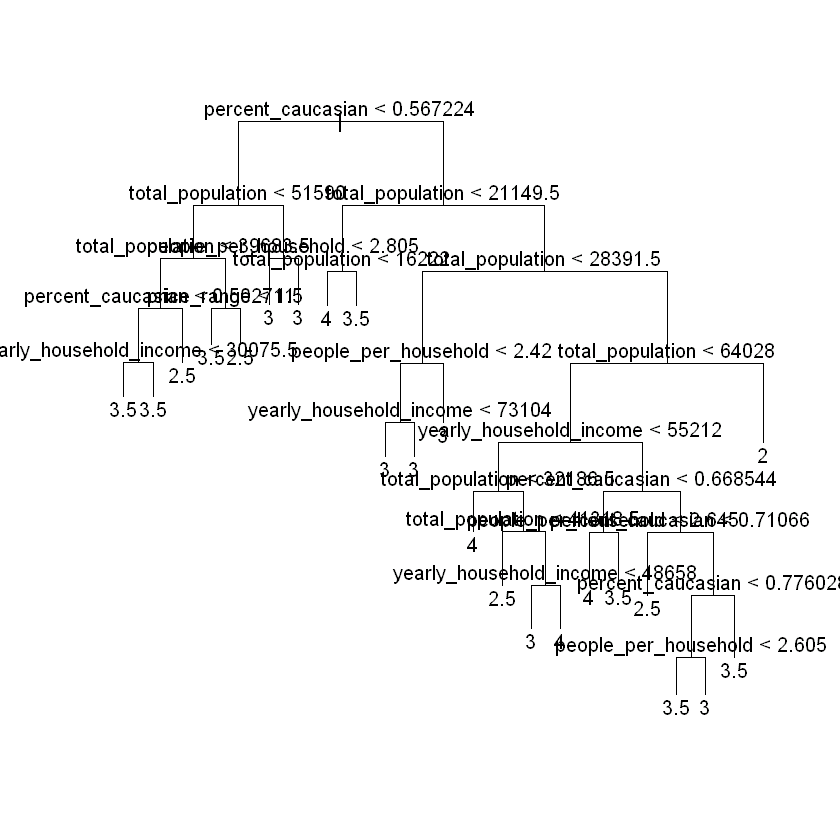

In [7]:
plot(tree.starbucks)
text(tree.starbucks, pretty = 0)

[1] 17

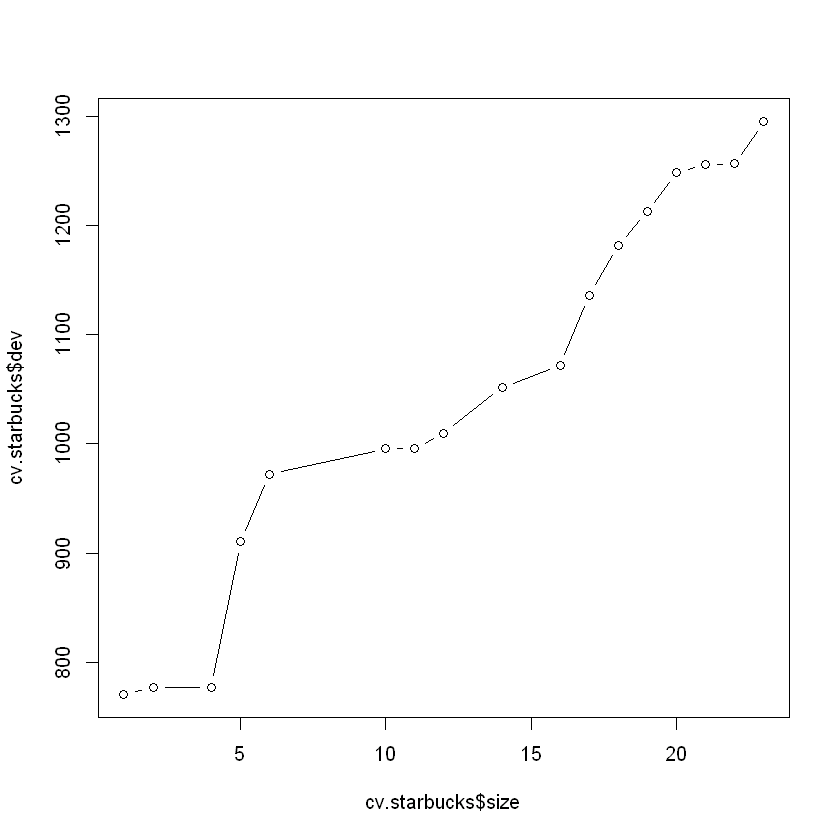

In [8]:
cv.starbucks = cv.tree(tree.starbucks)
plot(cv.starbucks$size, cv.starbucks$dev, type="b")
which.min(cv.starbucks$dev)

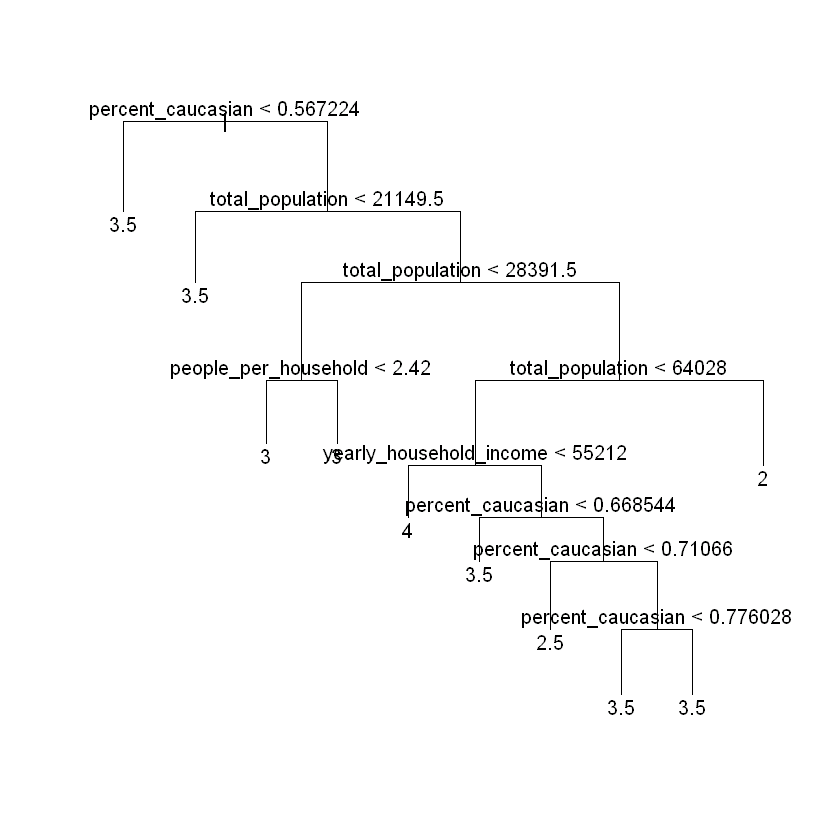

In [9]:
prune.starbucks2 = prune.tree(tree.starbucks, best = 10)
plot(prune.starbucks2)
text(prune.starbucks2, pretty = 0)
#we are over fitting

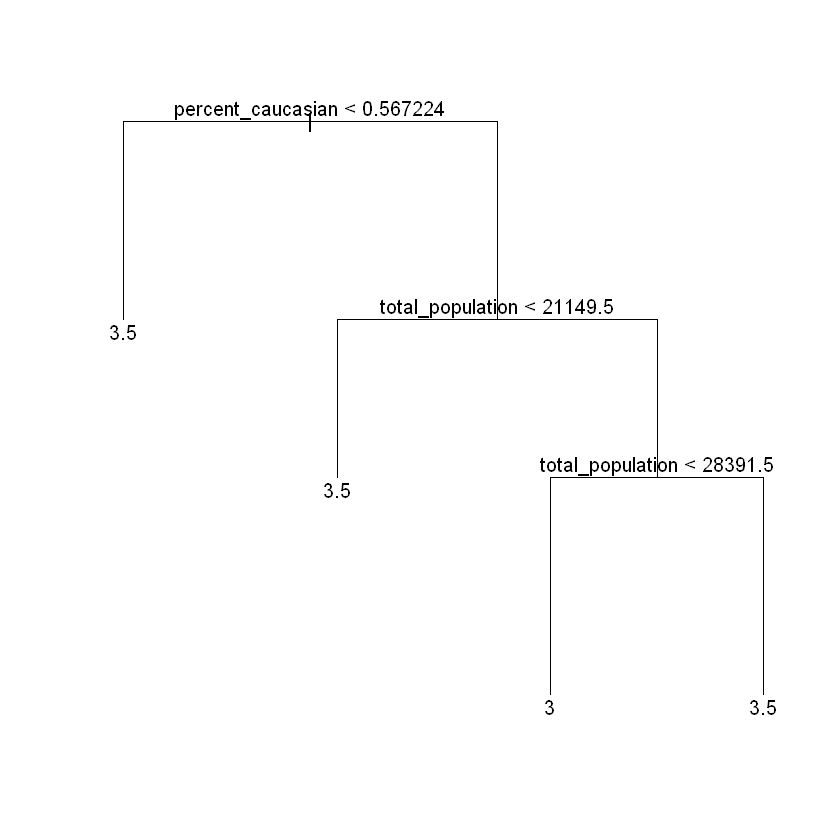

In [10]:
prune.starbucks3 = prune.tree(tree.starbucks, best = 4)
plot(prune.starbucks3)
text(prune.starbucks3, pretty = 0)

In [11]:
yhat = predict(prune.starbucks3, newdata = starbucks.scale[-train,])
mean((yhat-Starbucks[-train, "avg_stars"])^2)

plot(yhat,Starbucks[-train, "avg_stars"])
abline(0,1)

[1] 10.56843

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): plot.new has not been called yet


In [12]:
set.seed(1)
bag.starbucks = randomForest(avg_stars~., data = starbucks.scale, subset = train, mtry = 7, importance = TRUE)
bag.starbucks


Call:
 randomForest(formula = avg_stars ~ ., data = starbucks.scale,      mtry = 7, importance = TRUE, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 7

          Mean of squared residuals: 1.199881
                    % Var explained: -21.05

[1] 0.8994604

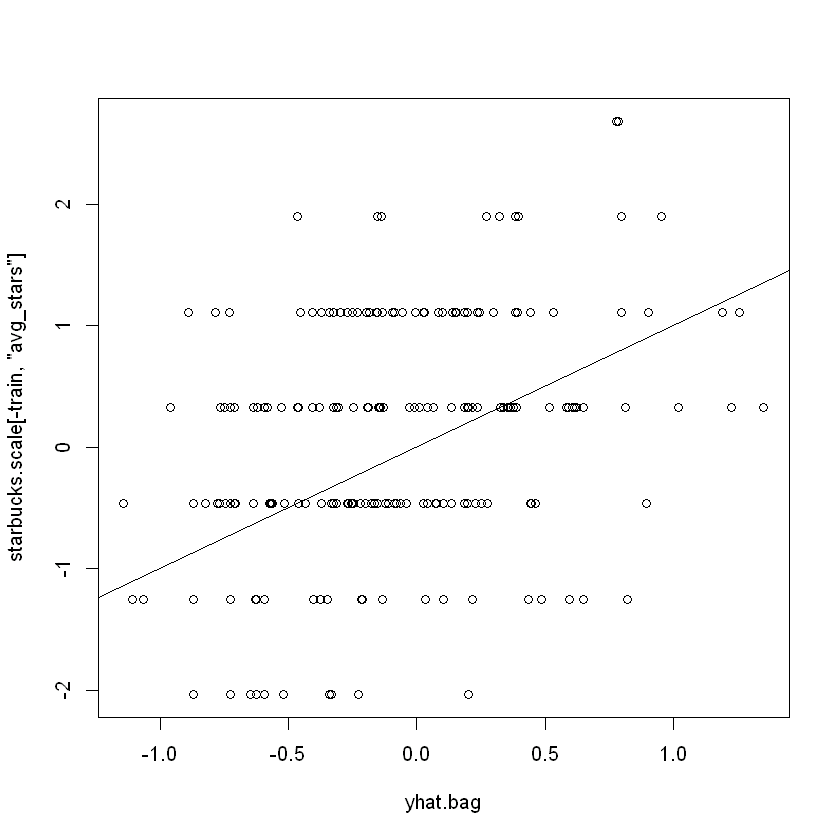

In [13]:
yhat.bag = predict(bag.starbucks,newdata=starbucks.scale[-train,])
plot(yhat.bag, starbucks.scale[-train, "avg_stars"])
abline(0,1)
mean((yhat.bag-starbucks.scale[-train, "avg_stars"])^2)
#Seeing more of range

In [14]:
yhat.boost = predict(boost.starbucks,newdata=starbucks.scale[-train,], n.trees=5000)
mean((yhat.boost-starbucks.scale[-train,])^2)

[1] 23.55375

In [15]:
# Then need to do best-subset selection

library(leaps)
regfit.full = regsubsets(avg_stars~., data=starbucks.scale)
reg.summary = summary(regfit.full)


[1] 3

[1] 2

[1] 1

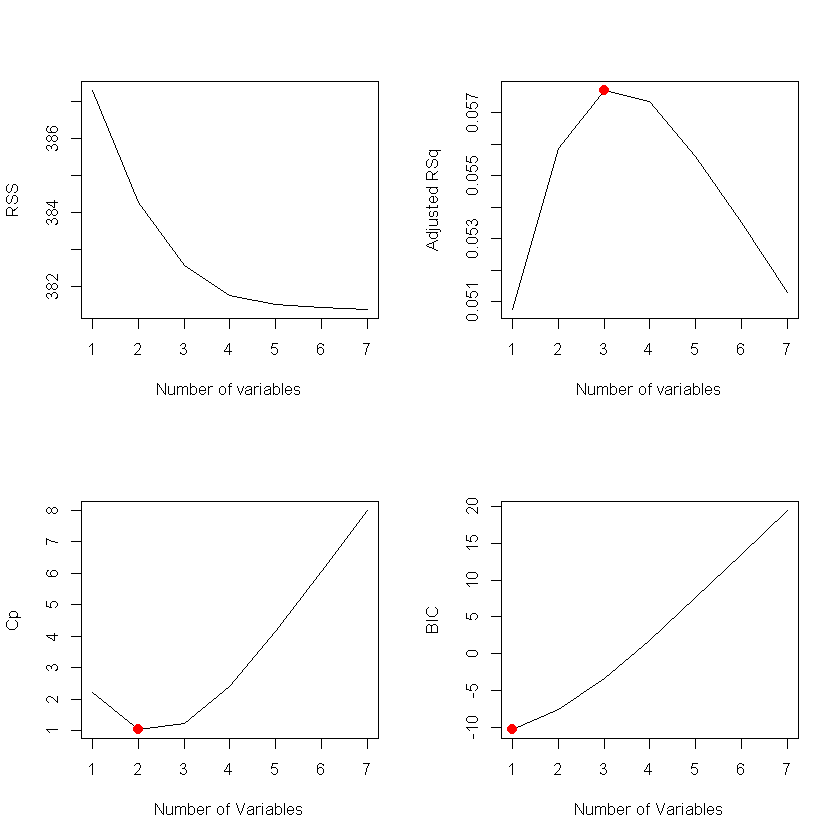

In [16]:
par(mfrow=c(2,2))
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted RSq", type="l")

which.max(reg.summary$adjr2) #3
points(3,reg.summary$adjr2[3], col ="red", cex = 2, pch = 20)

plot(reg.summary$cp, xlab = "Number of Variables", ylab = "Cp", type = "l")
which.min(reg.summary$cp) # 2
points(2, reg.summary$cp[2], col = "red", cex = 2, pch = 20)

plot(reg.summary$bic, xlab = "Number of Variables", ylab = "BIC", type = "l")
which.min(reg.summary$bic) # 1
points(1, reg.summary$bic[1], col = "red", cex = 2, pch = 20)

In [17]:
summary(regfit.full)
coef(regfit.full, 3)

Subset selection object
Call: regsubsets.formula(avg_stars ~ ., data = starbucks.scale)
7 Variables  (and intercept)
                         Forced in Forced out
total_population             FALSE      FALSE
percent_caucasian            FALSE      FALSE
has_wifi                     FALSE      FALSE
yearly_household_income      FALSE      FALSE
price_range                  FALSE      FALSE
people_per_household         FALSE      FALSE
is_wheelchair_accessible     FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: exhaustive
         total_population percent_caucasian has_wifi yearly_household_income
1  ( 1 ) " "              "*"               " "      " "                    
2  ( 1 ) " "              "*"               " "      " "                    
3  ( 1 ) " "              "*"               "*"      " "                    
4  ( 1 ) " "              "*"               "*"      " "                    
5  ( 1 ) "*"              "*"               "*"      " "           

(Intercept) percent_caucasian          has_wifi       price_range 
     3.658098e-16      2.327108e-01      6.462194e-02     -8.097302e-02

In [18]:
keeps = c("total_population", "percent_caucasian", "has_wifi", "yearly_household_income", "price_range", "people_per_household", "is_wheelchair_accessible")
#head(Starbucks[keeps])
pr.out=prcomp(starbucks.scale[keeps], scale=TRUE)
summary(pr.out)

Importance of components:
                         PC1    PC2    PC3    PC4    PC5     PC6     PC7
Standard deviation     1.357 1.1932 1.0767 0.9902 0.9101 0.77774 0.40361
Proportion of Variance 0.263 0.2034 0.1656 0.1401 0.1183 0.08641 0.02327
Cumulative Proportion  0.263 0.4663 0.6319 0.7720 0.8903 0.97673 1.00000

Loading required package: ggplot2
Warning message:
: package 'ggplot2' was built under R version 3.2.5
Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Loading required package: plyr
Warning message:
: package 'plyr' was built under R version 3.2.5Loading required package: scales
Warning message:
: package 'scales' was built under R version 3.2.5Loading required package: grid


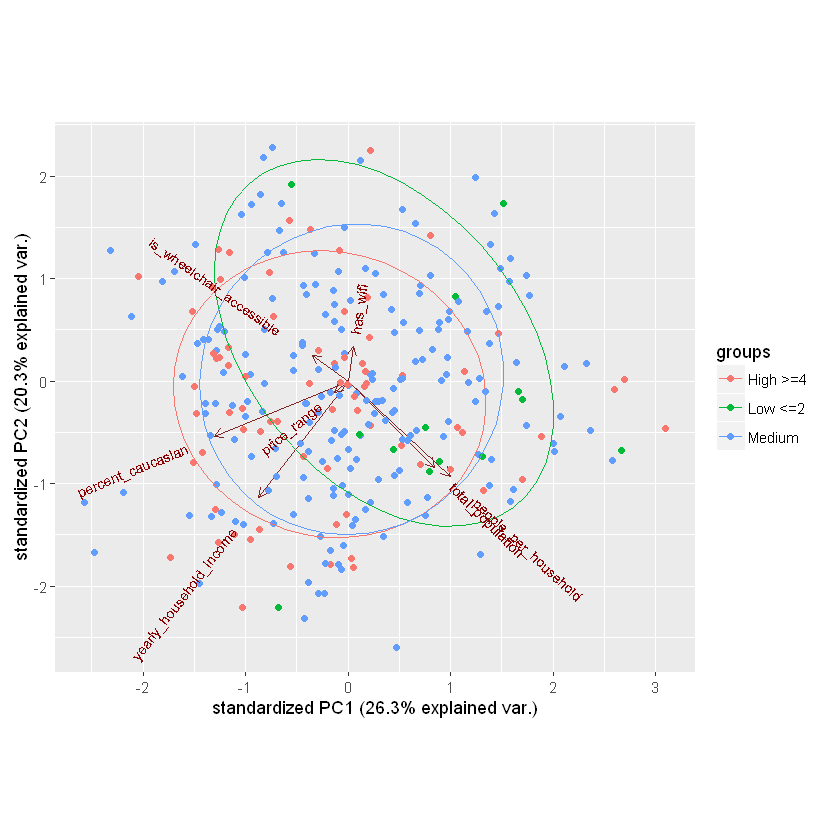

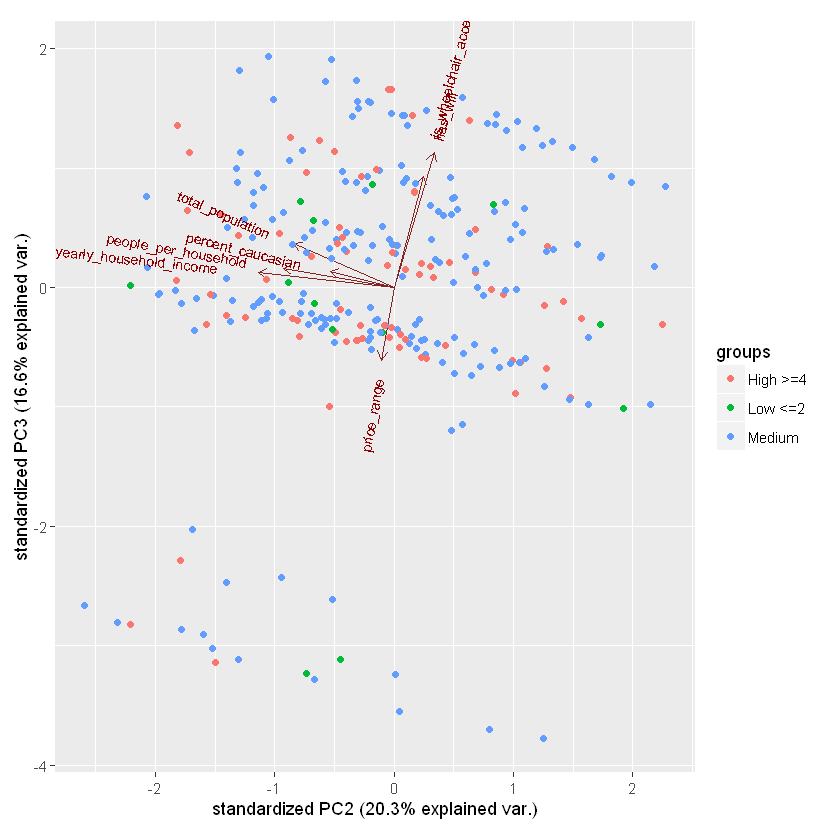

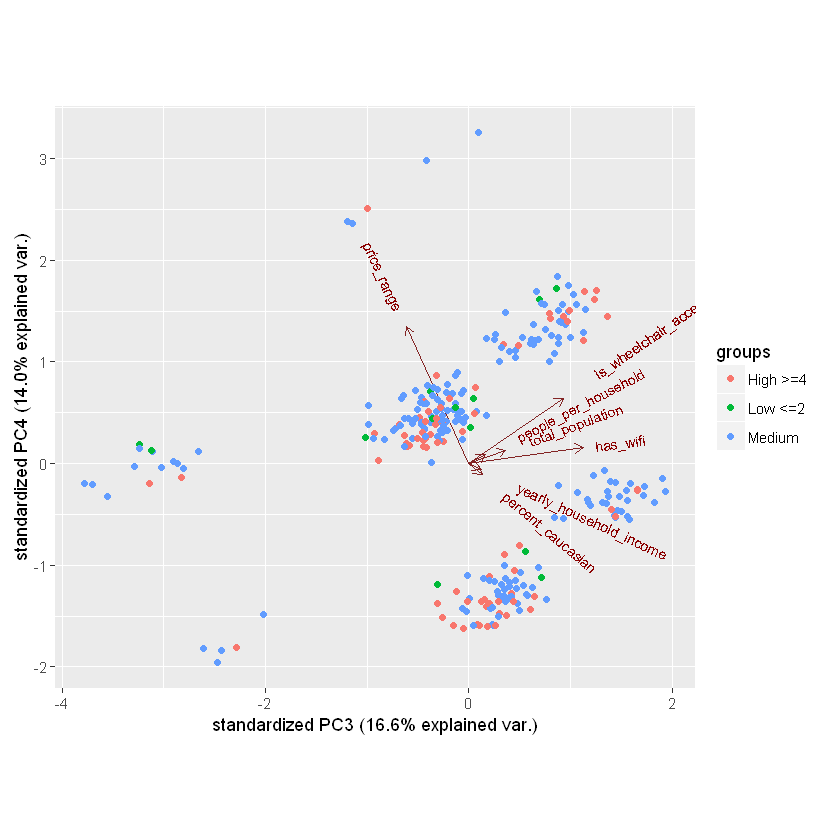

In [19]:
library(ggbiplot)
ggbiplot(pr.out, groups = ifelse(Starbucks$avg_stars<=2, "Low <=2", ifelse(Starbucks$avg_stars>=4, "High >=4", "Medium")), ellipse = TRUE) 
ggbiplot(pr.out, choices=2:3, groups = ifelse(Starbucks$avg_stars<=2, "Low <=2", ifelse(Starbucks$avg_stars>=4, "High >=4", "Medium"))) 
ggbiplot(pr.out, choices=3:4, groups = ifelse(Starbucks$avg_stars<=2, "Low <=2", ifelse(Starbucks$avg_stars>=4, "High >=4", "Medium")))

#+ scale_colour_manual(name = 'PC1 > 0', values = setNames(c('red','green', "grey"),c(T, F)))
#plot(pr.out$x[,3], pr.out$x[,4], pch="")
#text(pr.out$x[,1], pr.out$x[,2],labels = Starbucks$avg_stars, col = c("red", "blue"))
#biplot(pr.out, scale = 0, xlab = Starbucks$avg_stars, col=c("red", "blue", "green"))

     
       2 2.5  3 3.5  4 4.5  5
  1.5  0   0  0   0  0   0  0
  2    1   1  0   0  0   0  0
  2.5  0   1  0   1  1   0  0
  3    0   0  0   0  0   0  0
  3.5 10  25 58  54 42   9  2
  4    0   0  0   0  0   0  0
  4.5  0   0  0   0  0   0  0
  5    0   0  0   0  0   0  0

[1] 0.2731707

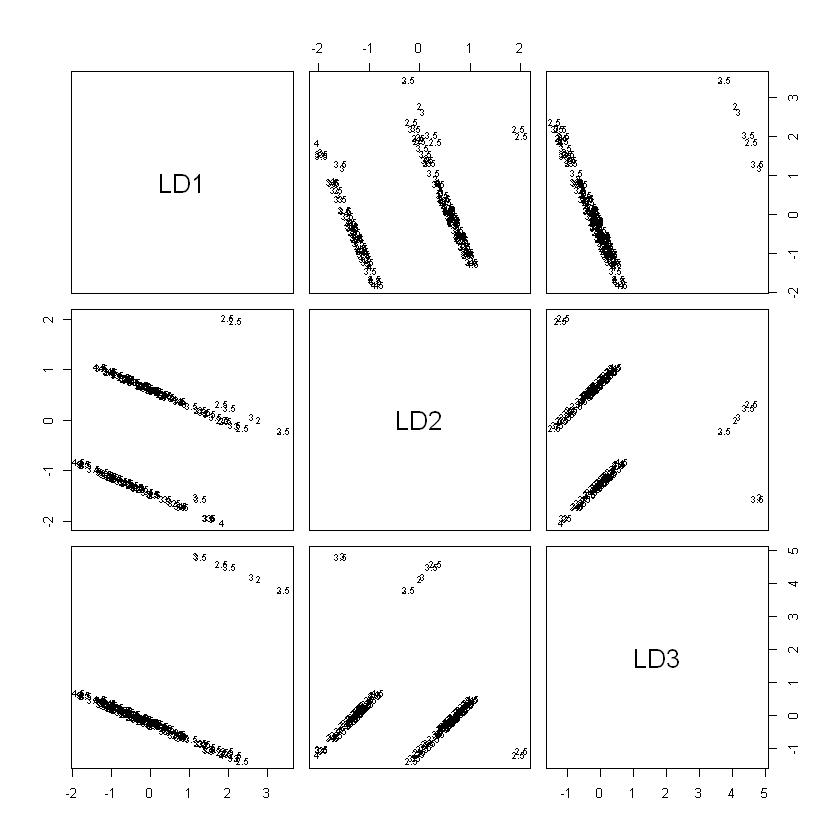

In [24]:
#---- LDA ------ go back and interpret
library(MASS)
#head(Starbucks)
#StarbucksLDA.fit = lda(avg_stars~.-has_credit_card_pay-has_outdoor_seating,data=Starbucks[train,])
StarbucksLDA.fit = lda(avg_stars~percent_caucasian+price_range+has_wifi,data=Starbucks[train,]) #+total_population+yearly_household_income+people_per_household+is_wheelchair_accessible
#summary(StarbucksLDA.fit)
StarbucksLDA.pred = predict(StarbucksLDA.fit, Starbucks[-train,])
table(StarbucksLDA.pred$class,Starbucks[-train,]$avg_stars)
mean(StarbucksLDA.pred$class==Starbucks[-train,]$avg_stars)
plot(StarbucksLDA.fit)

In [44]:
head(Starbucks)

,total_population,avg_stars,percent_white_people,has_wifi,yearly_household_income,price_range,people_per_household,is_wheelchair_accessible
1,18678,3.5,0.7756184,1,40733,2,2.17,1
2,17643,4.5,0.7830868,1,64581,2,2.18,1
3,3638,3.5,0.7616822,1,72400,2,1.41,0
4,3638,4,0.7616822,1,72400,2,1.41,0
5,10780,3,0.6868275,1,39040,2,1.99,0
6,10000,3.5,0.5661,1,48598,1,2.56,0


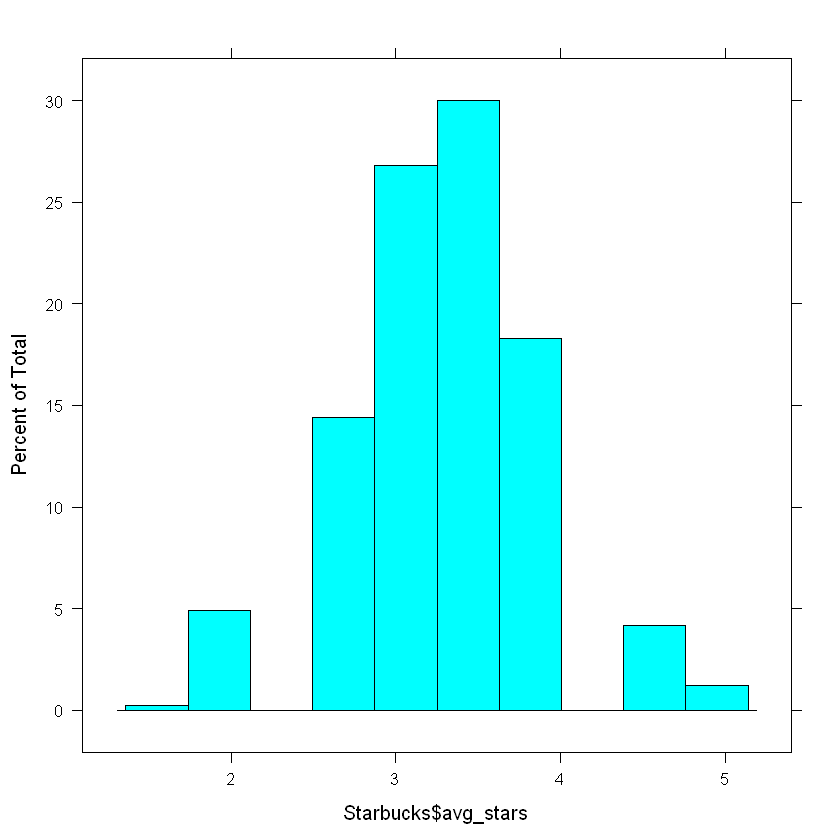

In [21]:
histogram(Starbucks$avg_stars)